In [119]:
from io import StringIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import NaN
from functions import * # import functions from the .py file

from pylab import rcParams
rcParams["figure.figsize"] = 16, 4

PAYLOADSIZE = 14

if PAYLOADSIZE % 2 != 0:
    print("Alarm! the payload size is not even.")
NUM_16RND = (PAYLOADSIZE-2)//2 # how many 16 bits random number included in each frame
MAX_SEQ = 256 # (decimal) maximum seq number defined by the length of the seq, the length of seq is 1B

## Log file

**For a fair comparison between groups, must follow the output format below**
<br>$\color{red}{\text{timestamp_rx }|\text{ len [hex] } \text{ seq [hex] } \text{ payload [hex] }|\text{rssi}}$
<br>$\text{ len [hex]}$ = payload length + 1 (seq. field length [1B])
<br>$\text{ payload [hex]}$ should start with the pseudo sequence number [2B], indicates the starting byte's position in the file.
***
*Example log file output for one frame with reciever timestamp xxxx, frame length, seq number and random payload, received signal strength.*
<br>15:17:18.394 |0f 46 bd f8 f7 ea 41 ac 1b be 05 a0 7f d2 09 d4 |  -91 CRC error
<br>$\color{red}{\text{delimiter for four variables is "|" and delimiter for the payload each byte is the space " ".}}$

In [120]:
# define the file name
filename = "logs/home-field-testing-clicker-firefly/90cm_100k_44_42.txt"
# import file to jupyter notebook
df = readfile("./" + filename)
# check the imported data first 10 lines
df.head(10)

IsADirectoryError: [Errno 21] Is a directory: './logs/home-field-testing-clicker-firefly/'

In [ ]:
# delete the corrupted packets (PAYLOADSIZE + 2B pesudo sequence number)
df = df[df.payload.apply(lambda x: len(x)==((PAYLOADSIZE)*3-1))]
df.reset_index(inplace=True)

In [ ]:
# replace the resettable seq number to unresettable, for the purpose of reliability calculation
test = replace_seq(df.copy(), MAX_SEQ=256)
test.rename(columns = {'seq':'old_seq', 'new_seq':'seq'}, inplace = True)

# Time

## Definition

**Evaluation metric**
<br>*File Transmission Time: the total latency that certain amount of Data $F$ is delivered to the destination.*
<br> $File\ Delay = Rx\_timestamp[N] - Rx\_timestamp[0]$
<br> where $N$ is the last packet
***
**Interesting to look at**:
<br>*Timestamp difference*: $\Delta T[i] = Rx\_timestamp[i] - Tx\_timestamp[i]$
1. *Worst-case packet delay*: the delay of the packet that takes the longest time to traverse.
2. *Packet delay variation*: the std of the packet delay.

In [ ]:
# compute the file delay
file_delay = df.time_rx[len(df) - 1] - df.time_rx[0]
# convert the timedelta to s
file_delay_s = np.timedelta64(file_delay, "ms").astype(int) / 1000
print(f"The time it takes to transfer the file is : {file_delay}, which is {file_delay_s} seconds.")

The time it takes to transfer the file is : 0 days 00:01:43.176000, which is 103.176 seconds.


# Reliability

## Definition

**Evaluation metric**
<br>*Quality of data transfer.*
<br>*Bit Reliability*: The ratio of data bits correctly delivered to the data sink.
<br>*Bit Error Rate*: The ratio of data bits incorrectly delivered to the data sink.
$$Bit\ Reliability = 1 - BER = 1 - \frac{Number\ of\ wrong\ bit}{Total\ Number\ of\ bit\ sent}$$
***
**Interesting to look at**:
1. *Expected number of transmission*: the ratio of the number of packets correctly received by the data sink and the number of packets sent by the source.

$$ETX = \frac{Number\ of\ packet\ received}{Number\ of\ packet\ sent}$$

2. *Packet reliability*: the number of packet bit correctly delivered to next hop.

## Statistics

In [ ]:
# compute the BER for all received packets
# return the in total ber for received file, error statistics and correct file content supposed to be transmitted
ber, error, file_content = compute_ber(test, PACKET_LEN=NUM_16RND*2, MAX_SEQ=MAX_SEQ)
bit_reliability = (1-ber)*100
print(f"Bit reliability [%]: {bit_reliability}")

The total number of packets transmitted by the tag is 4469.
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
26

In [ ]:
# payload example for debug purpose
# correct sequence for pesudoseq NO. '0000'
tmp = file_content.loc[int('0000', base=16), 'data']
for i in tmp:
    print("{:02x}".format(i), end=" ")

13 5d 1f 43 1b 45 25 6f 21 fe 0f 7e 

Text(0.5, 0, 'Seq. Number')

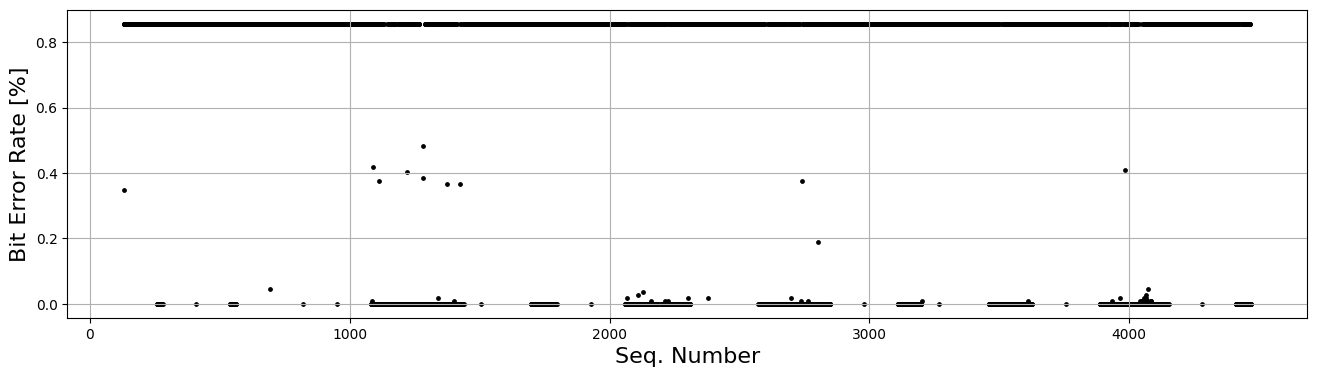

In [ ]:
# BER for each packet
plt.scatter(error.seq, error.bit_error/(PAYLOADSIZE*8), marker='o', s=6, color='black')
plt.grid()
plt.ylabel('Bit Error Rate [%]', fontsize=16)
plt.xlabel('Seq. Number', fontsize=16)

# Distance

## Definition

**The communication distance of the system.**
<br>$D_{1}$: the distance between carrier<->backscatter_tag[m]
<br>$D_{2}$: the distance between backscatter_tag<->receiver[m]
<br> Distance metric = $D_{1}^2D_{2}^2$
<br>

In [ ]:
# record the distance
dis_carrier_tag = 0.9
dis_tag_rx = 0.1

dis_metric = dis_carrier_tag**2*dis_tag_rx**2
print(f"Distance metric is: {dis_metric}")

Distance metric is: 0.008100000000000001


# Radarplot

**Please pay attention to the unit**
<br> <font color='red'>Time</font>: use second as unit
<br> <font color='red'>Reliability</font>: use the percent as unit
<br> <font color='red'>Distance</font>: use meter as unit
<br>**Metics = [Time(s), Reliability(%), Distance(m)]**
<br> <font color='red'>Always keep the reference in your plot.</font>
<br> Tips: for ploting, time metric uses $\frac{1}{Time}*1000$ as the time metric, the higher the value the better the system performance

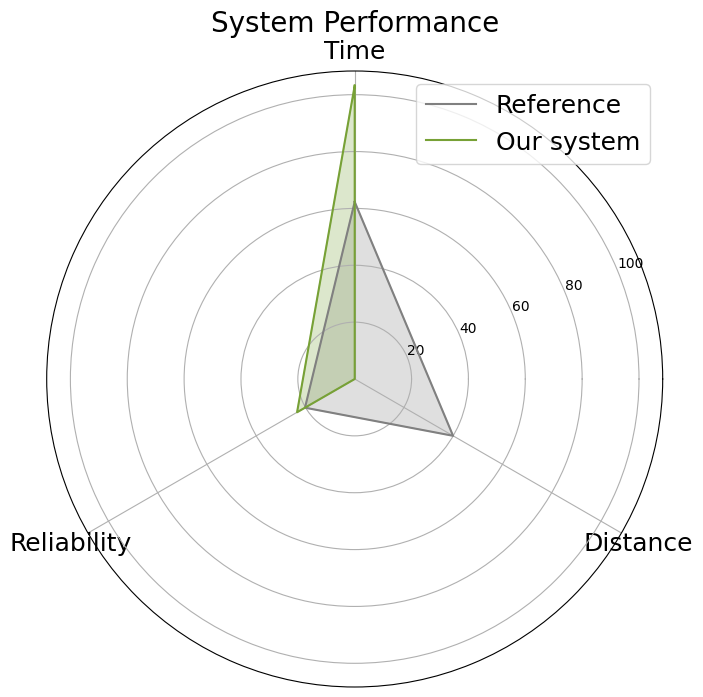

In [ ]:
metrics = [file_delay_s, bit_reliability, dis_metric]
radar_plot(metrics)